In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils, probeReadWrite
from pyCascade.probeReadWrite import read_probes_file_switch
from filloutVentilationStats import *
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import matplotlib.ticker as ticker
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from cycler import cycler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import statsmodels.api as sm
import warnings
import ast
from scipy.optimize import minimize_scalar

plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

# Setup

## Runs

In [2]:
runs = {
    246: {'A': 45, 'WS': 2, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    247: {'A': 45, 'WS': 4, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    248: {'A': 0,  'WS': 2, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    249: {'A': 0,  'WS': 4, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    216: {'A': 45, 'WS': 2, 'C': 3, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    217: {'A': 0,  'WS': 2, 'C': 3, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    218: {'A': 45, 'WS': 4, 'C': 3, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    219: {'A': 0,  'WS': 4, 'C': 3, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
}

multiRun_dir = f"{home_dir}/CHARLES/multiRuns/"
plotFolder = f"{multiRun_dir}"

## Read in results

In [3]:
def evalStringAsList(s):
    if isinstance(s, str) and s[0] == "[" and s[-1] == "]":
        return ast.literal_eval(s)
    else:
        return s

In [4]:
overWrite = False
if os.path.exists(f"{multiRun_dir}/roomVentilationMI.csv") == False or os.path.exists(f"{multiRun_dir}/flowStatsMI.csv") == False or overWrite:
    flowStatsMI, roomVentilationMI = readRunStats(runs, home_dir, scratch_dir, multiRun_dir = plotFolder)
else:
    flowStatsMI = pd.read_csv(f"{multiRun_dir}/flowStatsMI.csv", index_col=[0,1])
    roomVentilationMI = pd.read_csv(f"{multiRun_dir}/roomVentilationMI.csv", index_col=[0,1])
    flowStatsMI = flowStatsMI.map(evalStringAsList)
    roomVentilationMI = roomVentilationMI.map(evalStringAsList)


In [5]:
g = 10
beta = 0.0034
hm = 6
window_dim = hm/2/4
A = window_dim ** 2

def flowFromP(rho, C_d, A, delp):
    delp=np.array(delp)
    S = np.zeros_like(delp)
    S[delp!=0] = abs(delp[delp!=0]) / delp[delp!=0]
    return S * C_d * A * np.sqrt(2 * abs(delp) / rho)

def CFromFlow(rho, q, A, delp):
    delp=np.array(delp)
    S = np.zeros_like(delp)
    S[delp!=0] = abs(delp[delp!=0]) / delp[delp!=0]
    C = q /  (S * A * np.sqrt(2 * abs(delp) / rho))
    return C

def flowField(p_0, rho, flowParams):
    qs = []
    for i in range(len(flowParams["A"])):
        C_d = flowParams["C_d"][i]
        A = flowParams["A"][i]
        p_w = flowParams["p_w"][i]
        z = flowParams["z"][i]
        delT = flowParams["delT"][i]
        delrho = beta * delT
        delP = -p_0 - (delrho * g * z) + p_w # delP is outdoor minus indoor, driving positive flow into the room
        qs.append(flowFromP(rho, C_d, A, delP))
    return qs

def getC(p_0, rho, flowParams):
    Cs = []
    for i in range(len(flowParams["A"])):
        A = flowParams["A"][i]
        p_w = flowParams["p_w"][i]
        z = flowParams["z"][i]
        delT = flowParams["delT"][i]
        q = flowParams["q"][i]
        delrho = beta * delT
        delP = -p_0 - (delrho * g * z) + p_w # delP is outdoor minus indoor, driving positive flow into the room
        Cs.append(CFromFlow(rho, q, A, delP))
    return Cs

def qObjective(p_0, rho, flowParams):
    qs = flowField(p_0, rho, flowParams)
    return sum(qs)**2
    


In [6]:
flowParams = {
    "C_d": [1, 1, 1, 1],
    "A": [1, 1, 1, 1],
    "p_w": [1, 3, 5, 4],
    "z": [3, 3, 6, 3],
    "delT": [3, 3, 3, 3],
    "q": [1, 1, 1, 1]
}

# flowParams = {
#     "C_d": [1],
#     "A": [1],
#     "p_w": [1],
#     "z": [3],
#     "delT": [3],
#     "q": [1]
# }

display(flowField(-1, 1000, flowParams))
display(qObjective(-1, 1000, flowParams))
display(getC(-1, 1000, flowParams))


[0.05820652884342099,
 0.08595347578777719,
 0.10380751417888784,
 0.0968916921103146]

0.11892787535664136

[17.180203318601237, 11.634200837544286, 9.633214010661455, 10.32080231256014]

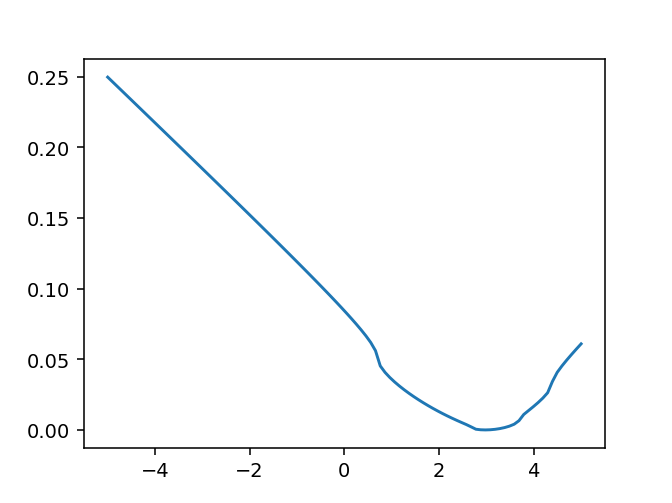

In [7]:
plt.figure()
p0 = np.linspace(-5, 5, 100)
plt.plot(p0, qObjective(p0, 1000, flowParams))

In [8]:
bounds = [min(flowParams["p_w"]), max(flowParams["p_w"])]

optResults = minimize_scalar(qObjective, bounds=bounds, args=(rho, flowParams))
display(optResults.x)

2.973357025982247

In [21]:
roomVentilationMI["p0_success"] = False
roomVentilationMI["EP_p0_success"] = False
for (run, room), row  in roomVentilationMI.iterrows():
    flowParams = {
        "C_d": [],
        "A": [],
        "p_w": [],
        "EP_p": [],
        "z": [],
        "delT": [],
        "q": [],
    }
    for windowKey in row["windowKeys"]:
        flowParams["C_d"].append(1)
        flowParams["A"].append(A)
        flowParams["p_w"].append(flowStatsMI.loc[(run, windowKey), "mean-sn_prod(p)"])
        flowParams["EP_p"].append(flowStatsMI.loc[(run, windowKey), "EP_p_avg"])
        flowParams["z"].append(flowStatsMI.loc[(run, windowKey), "y"]) # y is vertical in simulation
        flowParams["delT"].append(row["mean-T-room"])
        flowParams["q"].append(flowStatsMI.loc[(run, windowKey), "mean-mass_flux"])

    bounds = [-100, 100]
    optResults = minimize_scalar(qObjective, bounds=bounds, args=(rho, flowParams))
    p0 = optResults.x
    roomVentilationMI.loc[(run, room), "p0"] = p0
    roomVentilationMI.loc[(run, room), "p0_success"] = optResults.success

    qs = flowField(optResults.x, rho, flowParams)
    # p0 = row["mean-p-room"]
    C_ds = getC(p0, rho, flowParams)
    
    for i, windowKey in enumerate(row["windowKeys"]):
        flowStatsMI.loc[(run, windowKey), "q_model"] = qs[i]
        flowStatsMI.loc[(run, windowKey), "net-q_model"] = abs(qs[i])
        flowStatsMI.loc[(run, windowKey), "C_d"] = C_ds[i]
    roomVentilationMI.loc[(run, room), "q_model"] = np.sum(abs(np.array(qs)))

    flowParams["p_w"] = flowParams["EP_p"]
    optResults = minimize_scalar(qObjective, bounds=bounds, args=(rho, flowParams))
    EP_p0 = optResults.x
    roomVentilationMI.loc[(run, room), "EP_p0"] = EP_p0
    roomVentilationMI.loc[(run, room), "EP_p0_success"] = optResults.success

    qs = flowField(optResults.x, rho, flowParams)
    # EP_p0 = row["mean-p-room"]
    C_ds = getC(EP_p0, rho, flowParams)

    for i, windowKey in enumerate(row["windowKeys"]):
        flowStatsMI.loc[(run, windowKey), "EP_q_model"] = qs[i]
        flowStatsMI.loc[(run, windowKey), "EP_net-q_model"] = abs(qs[i])
        flowStatsMI.loc[(run, windowKey), "EP_C_d"] = C_ds[i]
    roomVentilationMI.loc[(run, room), "EP_q_model"] = np.sum(abs(np.array(qs)))    

In [30]:
px.scatter(data_frame=roomVentilationMI, x="mean-p-room", y='p0', symbol = "houseType", color = "roomType")

In [49]:
px.scatter(data_frame=roomVentilationMI, x="EP_p0", y='p0', symbol = "houseType", color = "roomType")

In [23]:
px.violin(data_frame=flowStatsMI, x="C_d", color = "AofA")

In [38]:
px.scatter(data_frame=flowStatsMI, x="mean-mass_flux", y='q_model', symbol = "openingType", color = "roomType")

In [47]:
px.scatter(data_frame=flowStatsMI, x="mean-mass_flux", y='EP_q_model', symbol = "openingType", color = "roomType")

In [34]:
px.scatter(data_frame=roomVentilationMI, x="mean-mass_flux", y='q_model', symbol = "houseType", color = "roomType")

In [40]:
px.scatter(data_frame=roomVentilationMI, x="mean-mass_flux", y='EP_q_model', symbol = "houseType", color = "roomType")

In [16]:
flowStats = flowStatsMI.loc[2480]
flowStats

mean-mass_flux  mean-mass_flux(D)  mean-mass_flux(S)  \
xwindow_0-0_h_0--1_B        0.044563          -0.019389          -0.046963   
zwindow_0-0_h_0--1_B       -0.043722          -0.031636          -0.069274   
zwindow_2-0_h_0--1_B       -0.026846          -0.049026          -0.067939   
zwindow_2-1_h_0--1_B        0.025421          -0.034416          -0.045730   
xwindow_0-1_h_0--1_B        0.003226          -0.034196          -0.068115   
...                              ...                ...                ...   
xwindow_0-1_sl_Bz           0.259777          -0.002141          -0.001153   
zwindow_0-1_sl_Bz          -0.147088          -0.029751          -0.094583   
zwindow_1-1_sl_Bz           0.193554          -0.005436          -0.016744   
skylight_1-0_sl_Bz          0.013581          -0.020532          -0.055806   
zwindow_1-0_sl_Bz          -0.011590          -0.032739          -0.080951   

                      mean-mass_flux(T)  mean-mass_flux(p)  \
xwindow_0-0_h_0--1_B                0.0           0.013850   
zwindow_0-0_h_0--1_B                0.0          -0.001379   
zwindow_2-0_h_0--1_B                0.0          -0.001520   
zwindow_2-1_h_0--1_B                0.0           0.012605   
xwindow_0-1_h_0--1_B                0.0           0.008503   
...                                 ...                ...   
xwindow_0-1_sl_Bz                   0.0          -0.025642   
zwindow_0-1_sl_Bz                   0.0           0.057559   
zwindow_1-1_sl_Bz                   0.0          -0.038838   
skylight_1-0_sl_Bz                  0.0           0.020383   
zwindow_1-0_sl_Bz                   0.0           0.008028   

                      mean-sn_prod(abs(u))  mean-sn_prod(p)  mean-sn_prod(u)  \
xwindow_0-0_h_0--1_B              0.174495         0.124905         0.017006   
zwindow_0-0_h_0--1_B              0.150738         0.116316        -0.032666   
zwindow_2-0_h_0--1_B              0.145699         0.149686        -0.021728   
zwindow_2-1_h_0--1_B              0.144645         0.152540         0.016027   
xwindow_0-1_h_0--1_B              0.180498         0.074285        -0.018695   
...                                    ...              ...              ...   
xwindow_0-1_sl_Bz                 0.236645        -0.107293         0.196075   
zwindow_0-1_sl_Bz                 0.213377        -0.218854        -0.112221   
zwindow_1-1_sl_Bz                 0.220164        -0.181453         0.145566   
skylight_1-0_sl_Bz                0.218994         0.322190         0.019478   
zwindow_1-0_sl_Bz                 0.224859         0.308512        -0.008516   

                      mean-sn_prod(u**2)  rms-mass_flux  ...  \
xwindow_0-0_h_0--1_B            0.051288       0.174065  ...   
zwindow_0-0_h_0--1_B            0.040165       0.172190  ...   
zwindow_2-0_h_0--1_B            0.039551       0.164322  ...   
zwindow_2-1_h_0--1_B            0.036245       0.164328  ...   
xwindow_0-1_h_0--1_B            0.055420       0.199563  ...   
...                                  ...            ...  ...   
xwindow_0-1_sl_Bz               0.089448       0.169895  ...   
zwindow_0-1_sl_Bz               0.074374       0.250286  ...   
zwindow_1-1_sl_Bz               0.077052       0.219083  ...   
skylight_1-0_sl_Bz              0.093133       0.298756  ...   
zwindow_1-0_sl_Bz               0.084704       0.300517  ...   

                      net-sn_prod(abs(u))-NormEP  net-sn_prod(abs(u))-NormEPR  \
xwindow_0-0_h_0--1_B                    0.274423                     0.110978   
zwindow_0-0_h_0--1_B                    0.107556                     0.095869   
zwindow_2-0_h_0--1_B                    0.167255                     0.092664   
zwindow_2-1_h_0--1_B                    0.392906                     0.091994   
xwindow_0-1_h_0--1_B                    0.140057                     0.114796   
...                                          ...                          ...   
xwindow_0-1_sl_Bz                       0.8

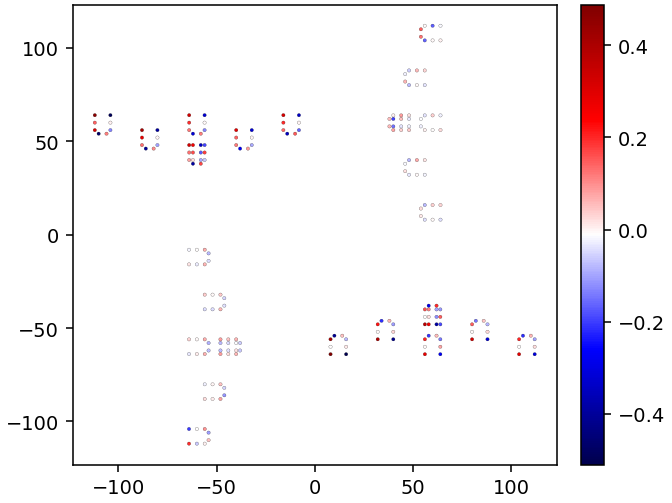

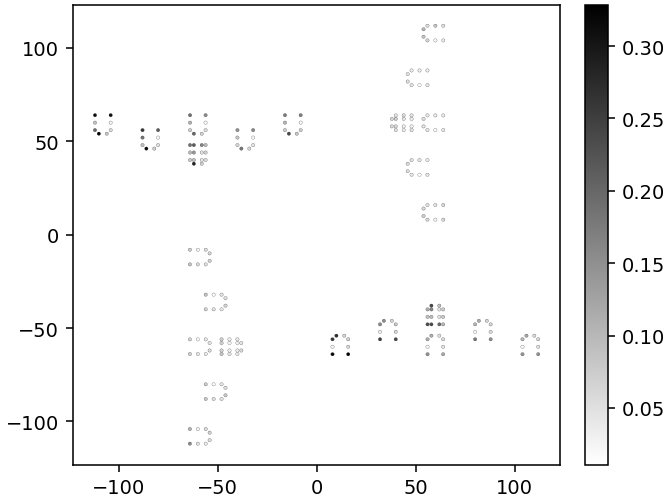

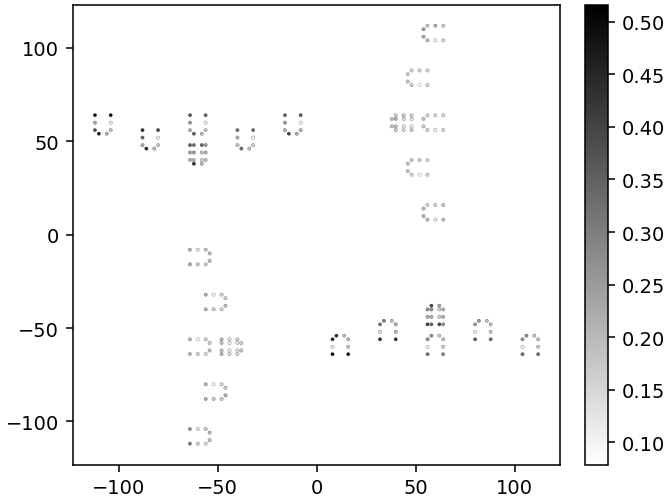

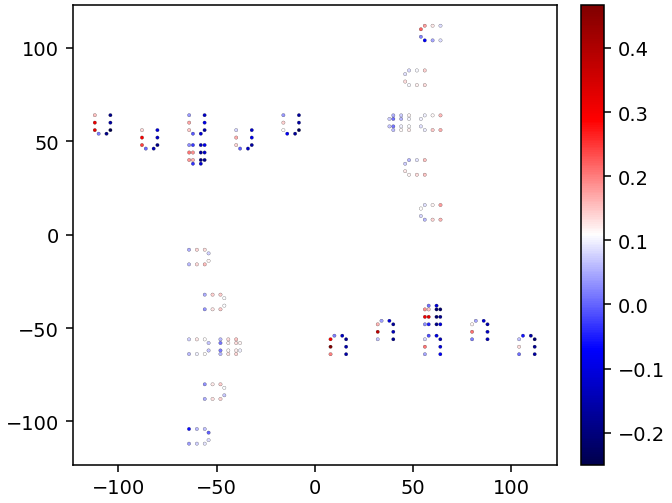

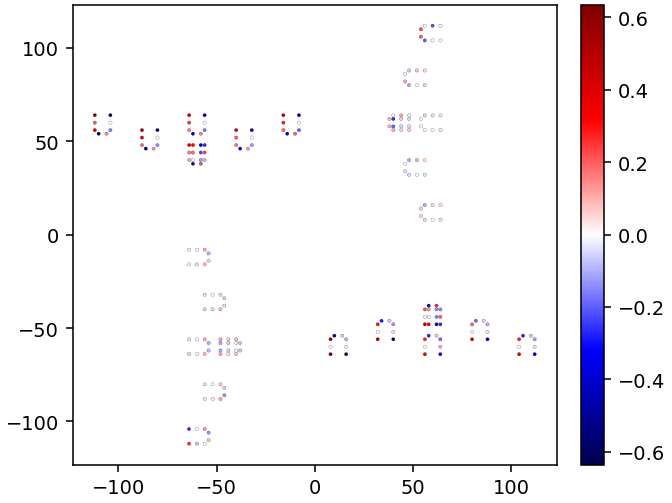

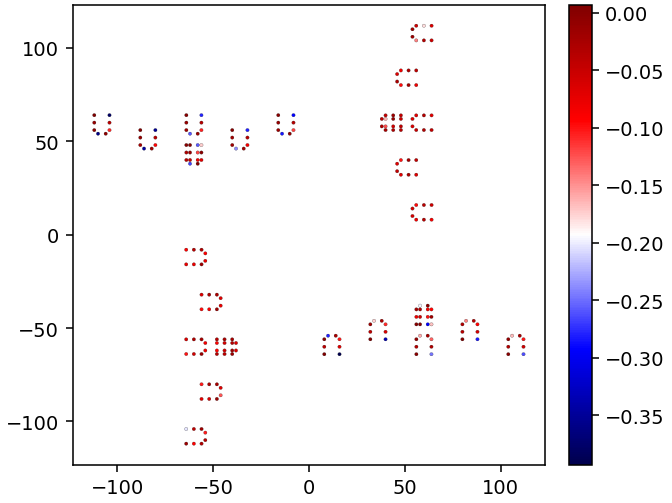

In [17]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean-sn_prod(u)"], cmap='seismic', edgecolors="black", linewidths=.1)
fig.colorbar(im)

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean-sn_prod(u**2)"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean-sn_prod(abs(u))"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean-sn_prod(p)"], cmap='seismic', edgecolors="black", linewidths=.1)
fig.colorbar(im)

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean-mass_flux"], cmap='seismic', edgecolors="black", linewidths=.1)
fig.colorbar(im)

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(flowStats['x'], flowStats['z'], s=4*im_scaling, c=flowStats["mean-mass_flux(S)"], cmap='seismic', edgecolors="black", linewidths=.1)
fig.colorbar(im)